# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr is added
sys.path:  ['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame/setup/.venv/lib/python3.12/site-packages', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr']


## 1. Create Bedrock client
Amazon Bedrock을 API로 활용하기 위한 Client를 설정합니다. 

In [4]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Comma

## 2. Titan Embedding v2 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [6]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-7-Sonnet-CRI"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 8192,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7449d053fcb0>], client=<botocore.client.BedrockRuntime object at 0x7449dc029e20>, model_id='us.anthropic.claude-3-7-sonnet-20250219-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=8192)

### Embedding 모델 선택

In [8]:
from langchain_aws import BedrockEmbeddings

In [9]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024 #1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 

### Extract Text, Table and Image from documents

### 3.1 Upstage Document Parse
- ### Prerequisites
    - #### 해당 에셋은 complex document parsing을 위해 [Upstage Document Parse](https://aws.amazon.com/marketplace/pp/prodview-lv5bnpdco7xoq?sr=0-4&ref_=beagle&applicationId=AWSMPContessa)을 이용합니다. 
    - Upstage Document Parse는 AWS Marketplace에 등록되어 있으며, Amazon SageMaker Endpoint 생성을 통해 사용하실 수 있습니다.
        - Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.
- ### **[API Description](https://developers.upstage.ai/docs/apis/document-parse)**


In [10]:
import shutil
from glob import glob
from requests_toolbelt import MultipartEncoder

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

from utils.common_utils import to_pickle, load_pickle
from langchain.schema import Document

**엔드포인트 이름을 입력합니다.**
- Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.

In [11]:
endpoint_document_parser = "<your endpont>"
endpoint_document_parser = "Upstage-Document-Parse-2025-07-22-06-56-52-438"

**추출할 문서의 위치를 입력합니다.**

In [12]:
#file_path = "./data/complex_pdf/school_edu_guide.pdf"
file_path = "./data/complex_pdf/sample-2.pdf"

**추출된 이미지가 저장될 위치를 입력합니다.**

In [13]:
image_path = "./fig"

**문서 파싱을 시작합니다 (약 1분 소요)**

In [14]:
%%time

if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

runtime_sm_client = boto3.client('runtime.sagemaker')

# Prepare multipart form data
encoder = MultipartEncoder(
    fields={
        'document': (os.path.basename(file_path), open(file_path, 'rb'), 'application/pdf'),
        'model': 'document-parse',
        'ocr': 'auto',
        'coordinates': 'true',
        'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
        'base64_encoding': '["table", "figure"]',
        'chart_recognition': 'true',
    }
)

# Get the raw bytes of the multipart form data
body = encoder.to_string()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_document_parser,
    ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
    Body=body
)

result = response["Body"].read()
parse_output = json.loads(result)

CPU times: user 96.5 ms, sys: 21.1 ms, total: 118 ms
Wall time: 2.87 s


In [15]:
to_pickle(parse_output, "parse_output.pkl")

To_PICKLE: parse_output.pkl


In [16]:
parse_output = load_pickle("parse_output.pkl")

Load from parse_output.pkl


In [17]:
#parse_output["elements"][1]#.keys()

**문서 파싱 후처리를 합니다.**
- docs: 문서는 페이지별 정리
- texts: markdown 형식의 전체 texts

In [18]:
def postprocessing(**kwargs):
    
    category = kwargs["category"]
    markdown = kwargs["markdown"]
    base64_encoding = kwargs["base64_encoding"]
    coordinates = kwargs["coordinates"]
    page = kwargs["page"]
    docs = kwargs["docs"]
    
    if page in docs: 
        docs[page].append({"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates})
    else:
        docs[page] = [{"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates}]
        
    return docs

def extract_image_table(**kwargs):
    
    image_path = kwargs["image_path"]
    file_path = kwargs["file_path"]
    
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)

    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")
        
    return image_tmp_path

pdf page 0, size: (1653, 2339)
pdf page 1, size: (1653, 2339)
pdf page 2, size: (1653, 2339)


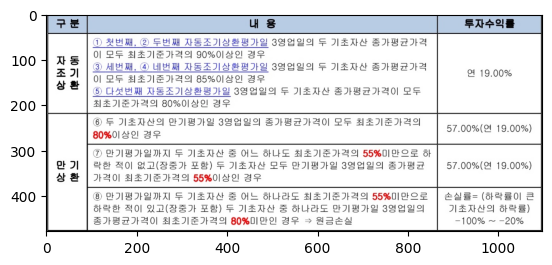

page_number: 1
==
image: ./fig/element-11.jpg, shape: (1462, 638), image_token_for_claude3: 1243.6746666666666


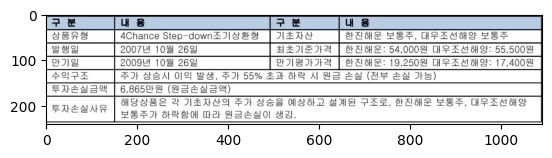

page_number: 2
==
image: ./fig/element-18.jpg, shape: (1455, 321), image_token_for_claude3: 622.74


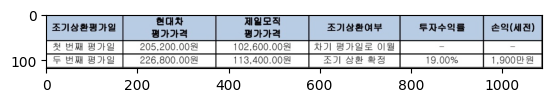

page_number: 3
==
image: ./fig/element-43.jpg, shape: (1452, 158), image_token_for_claude3: 305.888


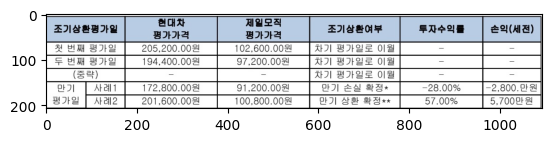

page_number: 3
==
image: ./fig/element-45.jpg, shape: (1458, 277), image_token_for_claude3: 538.488


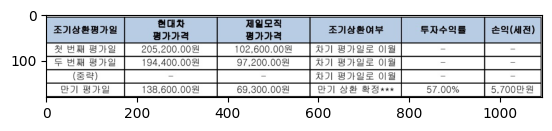

page_number: 3
==
image: ./fig/element-48.jpg, shape: (1458, 240), image_token_for_claude3: 466.56


In [19]:
docs = {}
texts = [
    Document(
        page_content=parse_output["content"]["markdown"]
    )
]

## extract_image_table
image_tmp_path = extract_image_table(
    image_path=image_path,
    file_path=file_path
)

for idx, value in enumerate(parse_output["elements"]):
      
    category = value["category"]
    markdown = value["content"]["markdown"]
    page = value["page"]
    
    if category in ["figure", "table"]:
        
        base64_encoding = value["base64_encoding"]    
        coordinates = value["coordinates"]    
        img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
        plt.imshow(img)
        plt.show()
        
        # PIL로 이미지 로드
        page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
        w, h = page_img.size  # PIL은 (width, height) 순서
        
        # 좌표 계산
        left = math.ceil(coordinates[0]["x"] * w)
        top = math.ceil(coordinates[0]["y"] * h)
        right = math.ceil(coordinates[1]["x"] * w)
        bottom = math.ceil(coordinates[3]["y"] * h)
        
        # PIL로 이미지 크롭
        crop_img = page_img.crop((left, top, right, bottom))
                
        crob_image_path = f'{image_path}/element-{idx}.jpg'
        crop_img.save(crob_image_path)

        print (f'page_number: {page}')
        print ("==")

        w_crop, h_crop = crop_img.size
        image_token = w_crop*h_crop/750
        print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
        
    else:
        base64_encoding= ""
        coordinates=""

    docs = postprocessing(
        docs=docs,
        page=page,
        category=category,
        markdown=markdown,
        base64_encoding=base64_encoding,
        coordinates=coordinates
    )

### Summarization of table and image
- **Image 및 Table 내용을 text 기반으로 요약합니다.**
- **Image 및 Table이 포함된 페이지의 내용을 추가 정보로 사용하여 문맥을 고려한 요약을 합니다.**
- **이 과정은 image 및 table 정보를 embedding 기반 모델로 검색 가능하게 합니다.**
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [20]:
import copy
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

**요약 대상과 그에 대한 컨텍스트 정보를 구분합니다**

In [21]:
docs_for_summary = []
for page, elements in docs.items():
    
    elements = [element for element in elements if element["category"] != "footer"]
    print (f'page: {page}, # elements: {len(elements)}')
    
    for idx, element in enumerate(elements):
        
        category, markdown = element["category"], element["markdown"]
        print (f'element idx: {idx}, category: {element["category"]}')
        
        elements_copy = copy.deepcopy(elements)
        if category in ("figure", "table"):  
            
            summary_target = elements_copy.pop(idx)
            contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
            docs_for_summary.append(
                {
                    "target_category": summary_target["category"],
                    "target_base64": summary_target["base64_encoding"],
                    "target_markdown": summary_target["markdown"],
                    "contexts_markdown": contexts_markdown
                }
            )

page: 1, # elements: 14
element idx: 0, category: paragraph
element idx: 1, category: heading1
element idx: 2, category: paragraph
element idx: 3, category: heading1
element idx: 4, category: list
element idx: 5, category: paragraph
element idx: 6, category: paragraph
element idx: 7, category: paragraph
element idx: 8, category: list
element idx: 9, category: paragraph
element idx: 10, category: heading1
element idx: 11, category: table
element idx: 12, category: paragraph
element idx: 13, category: paragraph
page: 2, # elements: 23
element idx: 0, category: paragraph
element idx: 1, category: heading1
element idx: 2, category: heading1
element idx: 3, category: paragraph
element idx: 4, category: table
element idx: 5, category: paragraph
element idx: 6, category: heading1
element idx: 7, category: heading1
element idx: 8, category: paragraph
element idx: 9, category: paragraph
element idx: 10, category: list
element idx: 11, category: heading1
element idx: 12, category: paragraph
elem

In [22]:
docs_for_summary

[{'target_category': 'table',
  'target_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAd8ESQMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/APob/gpx4S+Ln7Rv/Bcaz/Zj0/8AbO+N/wANfCFj+y1a+Jxpvwn+I9zoiT6iPEV1amWREDRsWikCs2wOfKjG7C4rP/4da+KP+ksn7an/AIkBcf8Axiu1/akP/HSQw/6sptf/AFLJq95r6LLcJh6uFUpxTZ4uPxFenXtF2P

**정보를 요약합니다**

In [23]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from utils.common_utils import retry

In [24]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 <contexts>
                 {contexts}
                 </contexts>
                 
                 주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:
                 
                 1. <title> 태그 안의 제목을 정확히 제시해주세요.
                 2. <summary> 태그 안의 내용을 요약해주세요.
                 3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                 4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [25]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()

In [26]:
@retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
def summary_img(summarize_chain, image_base64, contexts):

    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    plt.imshow(img)
    plt.show()

    stream = summarize_chain.stream(
        {
            "image_base64": image_base64,
            "contexts": contexts
        }
    )
    response = ""
    for chunk in stream: response += chunk

    return response

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


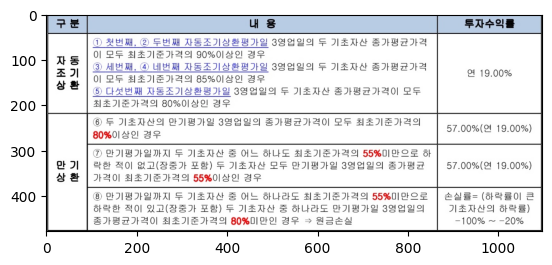

I'll analyze the image and extract the requested information based on the contexts provided.

# Analysis of the Table

The image shows a Korean financial document table that appears to detail investment conditions and returns for a structured financial product. The table consists of three rows with columns showing different categories and corresponding investment return rates.

The table is divided into sections:
1. "자동조기상환" (Automatic Early Redemption) section - showing conditions when returns would be 19%
2. "만기상환" (Maturity Redemption) section - showing conditions with returns of 57% (including 19%) under different scenarios
3. The last section appears to describe scenarios where principal losses occur between -100% to -20%

The table details specific thresholds related to underlying assets, showing:
- First and second cases requiring 90% or more of the initial reference price
- Third and fourth cases requiring 85% or more of the initial reference price  
- Fifth case requiring 80% 

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'I'll analyze the image and extract the requested information based on the contexts provided.

# Analysis of the Table

The image shows a Korean financial document table that appears to detail investment conditions and returns for a structured financial product. The table consists of three rows with columns showing different categories and corresponding investment return rates.

The table is divided into sections:
1. "자동조기상환" (Automatic Early Redemption) section - showing conditions when returns would be 19%
2. "만기상환" (Maturity Redemption) section - showing conditions with returns of 57% (including 19%) under different scenarios
3. The last section appears to describe scenarios where principal losses occur between -100% to -20%

The table details specific thresholds related to underlying assets, showing:
- First and second cases requiring 90% or more of the initial reference price
- Third and fourth cases requiring 85% or


==
0


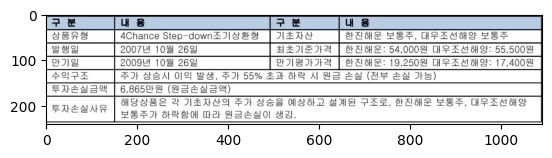

I'll analyze the table and contexts provided in the image.

The image shows a financial product information table with Korean text. The table has two main column pairs (구분/내용) that contain details about what appears to be an investment product called "4Chance Step-down" structured note.

## Key Information from the Table:

1. **상품유형 (Product Type)**: 4Chance Step-down 조기상환형 (Early redemption type)
2. **발행일 (Issuance Date)**: 2007년 10월 26일
3. **만기일 (Maturity Date)**: 2009년 10월 26일
4. **기초자산 (Underlying Assets)**: 한진해운 보통주, 대우조선해양 보통주
5. **초기 주가격 (Initial Prices)**: 한진해운: 54,000원, 대우조선해양: 55,500원
6. **만기 평가가격 (Maturity Evaluation Prices)**: 한진해운: 19,250원, 대우조선해양: 17,400원
7. **수익구조 (Return Structure)**: 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실
8. **투자손실금액 (Investment Loss Amount)**: 6,865만원 (원금손실금액)
9. **투자손실사유 (Reason for Investment Loss)**: 해당상품은 각 기초자산의 주가 하락을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 발생

The contexts section contains information about financial consumer protection, 

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'I'll analyze the table and contexts provided in the image.

The image shows a financial product information table with Korean text. The table has two main column pairs (구분/내용) that contain details about what appears to be an investment product called "4Chance Step-down" structured note.

## Key Information from the Table:

1. **상품유형 (Product Type)**: 4Chance Step-down 조기상환형 (Early redemption type)
2. **발행일 (Issuance Date)**: 2007년 10월 26일
3. **만기일 (Maturity Date)**: 2009년 10월 26일
4. **기초자산 (Underlying Assets)**: 한진해운 보통주, 대우조선해양 보통주
5. **초기 주가격 (Initial Prices)**: 한진해운: 54,000원, 대우조선해양: 55,500원
6. **만기 평가가격 (Maturity Evaluation Prices)**: 한진해운: 19,250원, 대우조선해양: 17,400원
7. **수익구조 (Return Structure)**: 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실
8. **투자손실금액 (Investment Loss Amount)**: 6,865만원 (원금손실금액)
9. **투자손실사유 (Reason for Investment Loss)**: 해당상품은 각 기초자산의 주가 하락을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 발생

The contexts 


==
1


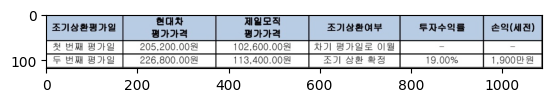

I'll analyze the provided table and contextual information for you.

## <title>
금융상품 조기상환 평가일 및 투자수익 정보

## <summary>
이 자료는 금융상품의 조기상환 평가일과 관련된 상환 조건을 보여주는 표입니다. 첫 번째와 두 번째 평가일에 대한 현대차와 제일모직의 평가가격 정보를 담고 있으며, 조기상환 여부와 투자수익률, 손익(세전) 정보를 제공합니다. 문서는 금융소비자의 권익 보호와 금융상품에 대한 이해 증진을 위한 설명서의 일부로, 상품의 손익구조와 투자 사례에 대해 자세히 설명하고 있습니다.

## <entities>
1. 조기상환평가일: 금융상품의 조기상환 가능성을 평가하는 일자
2. 현대차 평가가격: 기초자산인 현대차 주식의 평가 가격 (첫 번째 평가일 205,200원, 두 번째 평가일 226,800원)
3. 제일모직 평가가격: 기초자산인 제일모직 주식의 평가 가격 (첫 번째 평가일 102,600원, 두 번째 평가일 113,400원)
4. 조기상환여부: 해당 평가일에 조기상환 여부를 판단한 결과 (첫 번째는 차기 평가일로 이월, 두 번째는 조기상환 확정)
5. 투자수익률: 투자 시 얻을 수 있는 수익률 (두 번째 평가일에 19.00%)
6. 손익(세전): 투자금액에 대한 세전 손익 금액 (두 번째 평가일에 1,900만원)
7. 최초기준가격: 현대차 240,000원, 제일모직 120,000원으로 가정
8. 투자손익 사례: 1억원 투자 시 발생 가능한 다양한 시나리오별 손익 상황

## <hypothetical_questions>
1. 이 금융상품의 최대 수익률은 얼마인가요?
2. 조기상환이 발생하지 않을 경우, 만기에 손실이 발생할 수 있는 조건은 무엇인가요?
3. 현대차와 제일모직 주가가 최초기준가격의 55% 미만으로 하락한 적이 있을 때 어떤 영향이 있나요?
4. 만기평가일에 두 기초자산 모두 최초기준가격의 80% 이상일 경우 투자자에게 어떤 결과가 나타나나요?
5. 투자

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'I'll analyze the provided table and contextual information for you.

## <title>
금융상품 조기상환 평가일 및 투자수익 정보

## <summary>
이 자료는 금융상품의 조기상환 평가일과 관련된 상환 조건을 보여주는 표입니다. 첫 번째와 두 번째 평가일에 대한 현대차와 제일모직의 평가가격 정보를 담고 있으며, 조기상환 여부와 투자수익률, 손익(세전) 정보를 제공합니다. 문서는 금융소비자의 권익 보호와 금융상품에 대한 이해 증진을 위한 설명서의 일부로, 상품의 손익구조와 투자 사례에 대해 자세히 설명하고 있습니다.

## <entities>
1. 조기상환평가일: 금융상품의 조기상환 가능성을 평가하는 일자
2. 현대차 평가가격: 기초자산인 현대차 주식의 평가 가격 (첫 번째 평가일 205,200원, 두 번째 평가일 226,800원)
3. 제일모직 평가가격: 기초자산인 제일모직 주식의 평가 가격 (첫 번째 평가일 102,600원, 두 번째 평가일 113,400원)
4. 조기상환여부: 해당 평가일에 조기상환 여부를 판단한 결과 (첫 번째는 차기 평가일로 이월, 두 번째는 조기상환 확정)
5. 투자수익률: 투자 시 얻을 수 있는 수익률 (두 번째 평가일에 19.00%)
6. 손익(세전): 투자금액에 대한 세전 손익 금액 (두 번째 평가일에 1,900만원)
7. 최초기준가격: 현대차 240,000원, 제일모직 120,000원으로 가정
8. 투자손익 사례: 1억원 투자 시 발생 가능한 다양한 시나리오별 손익 상황

## <hypothetical_questions>
1. 이 금융상품의 최대 수익률은 얼마인가요?
2. 조기상환이 발생하지 않을 경우, 만기에 손실이 발생할 수 있는 조건은 무엇인가요?
3. 현대차와 제일모직 주가가 최초기준가격의 55% 미만으로 하락한 적이 있을 때 어떤 영향이 있나요


==
2


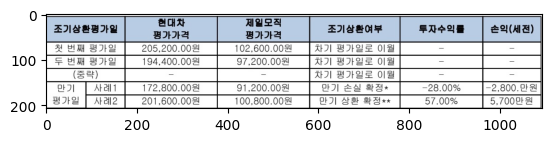

The image shows a financial product table that displays early redemption evaluation information. Let me analyze the content based on the provided context:

## Analysis of the Table and Context

The table contains columns for early redemption evaluation dates, evaluation prices for Hyundai Motor Company and Samsung C&T (formerly Cheil Industries), early redemption status, investment yield rates, and profit/loss information.

The table shows:
- First evaluation day: Hyundai Motor at 205,200 won, Samsung C&T at 102,600 won - transferred to next evaluation date
- Second evaluation day: Hyundai Motor at 194,400 won, Samsung C&T at 97,200 won - transferred to next evaluation date
- A scenario where the investment yields -28.00% loss (-2,800 million won)
- Another scenario with 57.00% return (5,700 million won)

From the context, this appears to be information about a structured financial product with auto-callable features based on the performance of two underlying assets (Hyundai Motor Comp

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'The image shows a financial product table that displays early redemption evaluation information. Let me analyze the content based on the provided context:

## Analysis of the Table and Context

The table contains columns for early redemption evaluation dates, evaluation prices for Hyundai Motor Company and Samsung C&T (formerly Cheil Industries), early redemption status, investment yield rates, and profit/loss information.

The table shows:
- First evaluation day: Hyundai Motor at 205,200 won, Samsung C&T at 102,600 won - transferred to next evaluation date
- Second evaluation day: Hyundai Motor at 194,400 won, Samsung C&T at 97,200 won - transferred to next evaluation date
- A scenario where the investment yields -28.00% loss (-2,800 million won)
- Another scenario with 57.00% return (5,700 million won)

From the context, this appears to be information about a structured financial product with auto-callable features bas


==
3


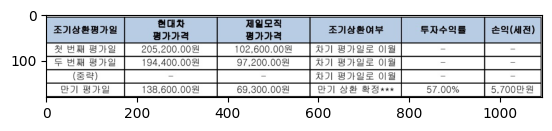

I'll analyze the provided table and context information:

## Analysis

The image shows a financial product table displaying information about early redemption evaluation dates, price evaluations for two underlying assets (현대차 and 제일모직), early redemption status, investment return rates, and profits/losses.

The table specifically shows:
- Multiple evaluation dates including first and second evaluation dates
- Price values for 현대차 (Hyundai Motor) and 제일모직 (Cheil Industries)
- Early redemption conditions
- Investment return rates
- Profit/loss calculations (in Korean won)

The surrounding context explains this is from a financial product disclosure document that details the structure of what appears to be an equity-linked security or note (ELS). The document includes information about potential investment scenarios, early redemption conditions, and risk factors.

## Extracted Information

<title>조기상환 시나리오 분석표</title>

<summary>
이 표는 금융상품(ELS 유형으로 추정)의 조기상환 및 만기상환 시나리오를 보여줍니다. 현대차와 제일모직을 기

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'I'll analyze the provided table and context information:

## Analysis

The image shows a financial product table displaying information about early redemption evaluation dates, price evaluations for two underlying assets (현대차 and 제일모직), early redemption status, investment return rates, and profits/losses.

The table specifically shows:
- Multiple evaluation dates including first and second evaluation dates
- Price values for 현대차 (Hyundai Motor) and 제일모직 (Cheil Industries)
- Early redemption conditions
- Investment return rates
- Profit/loss calculations (in Korean won)

The surrounding context explains this is from a financial product disclosure document that details the structure of what appears to be an equity-linked security or note (ELS). The document includes information about potential investment scenarios, early redemption conditions, and risk factors.

## Extracted Information

<title>조기상환 시나리오 분석표</title>

<summ


==
4


In [27]:
summaries = []
for idx, doc in enumerate(docs_for_summary):
    summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
    summaries.append(summary)
    print ("\n==")
    print (idx)

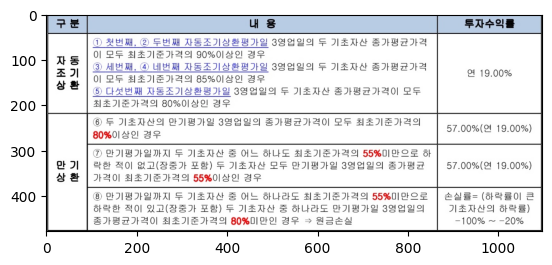

Summary: I'll analyze the image and extract the requested information based on the contexts provided.

# Analysis of the Table

The image shows a Korean financial document table that appears to detail investment conditions and returns for a structured financial product. The table consists of three rows with columns showing different categories and corresponding investment return rates.

The table is divided into sections:
1. "자동조기상환" (Automatic Early Redemption) section - showing conditions when returns would be 19%
2. "만기상환" (Maturity Redemption) section - showing conditions with returns of 57% (including 19%) under different scenarios
3. The last section appears to describe scenarios where principal losses occur between -100% to -20%

The table details specific thresholds related to underlying assets, showing:
- First and second cases requiring 90% or more of the initial reference price
- Third and fourth cases requiring 85% or more of the initial reference price  
- Fifth case requi

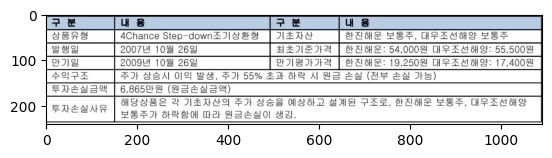

Summary: I'll analyze the table and contexts provided in the image.

The image shows a financial product information table with Korean text. The table has two main column pairs (구분/내용) that contain details about what appears to be an investment product called "4Chance Step-down" structured note.

## Key Information from the Table:

1. **상품유형 (Product Type)**: 4Chance Step-down 조기상환형 (Early redemption type)
2. **발행일 (Issuance Date)**: 2007년 10월 26일
3. **만기일 (Maturity Date)**: 2009년 10월 26일
4. **기초자산 (Underlying Assets)**: 한진해운 보통주, 대우조선해양 보통주
5. **초기 주가격 (Initial Prices)**: 한진해운: 54,000원, 대우조선해양: 55,500원
6. **만기 평가가격 (Maturity Evaluation Prices)**: 한진해운: 19,250원, 대우조선해양: 17,400원
7. **수익구조 (Return Structure)**: 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실
8. **투자손실금액 (Investment Loss Amount)**: 6,865만원 (원금손실금액)
9. **투자손실사유 (Reason for Investment Loss)**: 해당상품은 각 기초자산의 주가 하락을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 발생

The contexts section contains information about financial consumer pro

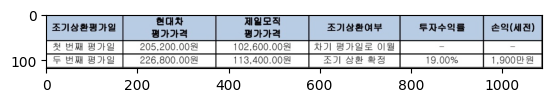

Summary: I'll analyze the provided table and contextual information for you.

## <title>
금융상품 조기상환 평가일 및 투자수익 정보

## <summary>
이 자료는 금융상품의 조기상환 평가일과 관련된 상환 조건을 보여주는 표입니다. 첫 번째와 두 번째 평가일에 대한 현대차와 제일모직의 평가가격 정보를 담고 있으며, 조기상환 여부와 투자수익률, 손익(세전) 정보를 제공합니다. 문서는 금융소비자의 권익 보호와 금융상품에 대한 이해 증진을 위한 설명서의 일부로, 상품의 손익구조와 투자 사례에 대해 자세히 설명하고 있습니다.

## <entities>
1. 조기상환평가일: 금융상품의 조기상환 가능성을 평가하는 일자
2. 현대차 평가가격: 기초자산인 현대차 주식의 평가 가격 (첫 번째 평가일 205,200원, 두 번째 평가일 226,800원)
3. 제일모직 평가가격: 기초자산인 제일모직 주식의 평가 가격 (첫 번째 평가일 102,600원, 두 번째 평가일 113,400원)
4. 조기상환여부: 해당 평가일에 조기상환 여부를 판단한 결과 (첫 번째는 차기 평가일로 이월, 두 번째는 조기상환 확정)
5. 투자수익률: 투자 시 얻을 수 있는 수익률 (두 번째 평가일에 19.00%)
6. 손익(세전): 투자금액에 대한 세전 손익 금액 (두 번째 평가일에 1,900만원)
7. 최초기준가격: 현대차 240,000원, 제일모직 120,000원으로 가정
8. 투자손익 사례: 1억원 투자 시 발생 가능한 다양한 시나리오별 손익 상황

## <hypothetical_questions>
1. 이 금융상품의 최대 수익률은 얼마인가요?
2. 조기상환이 발생하지 않을 경우, 만기에 손실이 발생할 수 있는 조건은 무엇인가요?
3. 현대차와 제일모직 주가가 최초기준가격의 55% 미만으로 하락한 적이 있을 때 어떤 영향이 있나요?
4. 만기평가일에 두 기초자산 모두 최초기준가격의 80% 이상일 경우 투자자에게 어떤 결과가 나타나

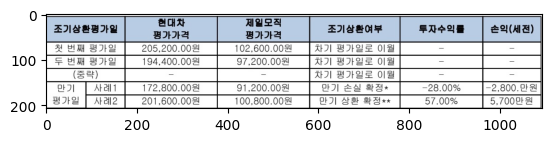

Summary: The image shows a financial product table that displays early redemption evaluation information. Let me analyze the content based on the provided context:

## Analysis of the Table and Context

The table contains columns for early redemption evaluation dates, evaluation prices for Hyundai Motor Company and Samsung C&T (formerly Cheil Industries), early redemption status, investment yield rates, and profit/loss information.

The table shows:
- First evaluation day: Hyundai Motor at 205,200 won, Samsung C&T at 102,600 won - transferred to next evaluation date
- Second evaluation day: Hyundai Motor at 194,400 won, Samsung C&T at 97,200 won - transferred to next evaluation date
- A scenario where the investment yields -28.00% loss (-2,800 million won)
- Another scenario with 57.00% return (5,700 million won)

From the context, this appears to be information about a structured financial product with auto-callable features based on the performance of two underlying assets (Hyundai M

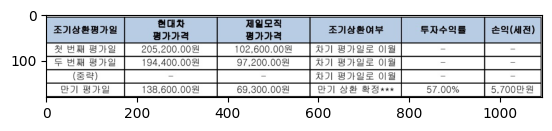

Summary: I'll analyze the provided table and context information:

## Analysis

The image shows a financial product table displaying information about early redemption evaluation dates, price evaluations for two underlying assets (현대차 and 제일모직), early redemption status, investment return rates, and profits/losses.

The table specifically shows:
- Multiple evaluation dates including first and second evaluation dates
- Price values for 현대차 (Hyundai Motor) and 제일모직 (Cheil Industries)
- Early redemption conditions
- Investment return rates
- Profit/loss calculations (in Korean won)

The surrounding context explains this is from a financial product disclosure document that details the structure of what appears to be an equity-linked security or note (ELS). The document includes information about potential investment scenarios, early redemption conditions, and risk factors.

## Extracted Information

<title>조기상환 시나리오 분석표</title>

<summary>
이 표는 금융상품(ELS 유형으로 추정)의 조기상환 및 만기상환 시나리오를 보여줍니다. 현대차

In [28]:
verbose = True
if verbose:
    for doc, summary in zip(docs_for_summary, summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(doc["target_base64"])))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [29]:
images_preprocessed = []

for doc, summary in zip(docs_for_summary, summaries):
    
    metadata = {}
    metadata["markdown"] = doc["target_markdown"]
    metadata["category"] = "Image"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [30]:
images_preprocessed[0]

Document(metadata={'markdown': '| 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- | --- |\n| 동자 동 자 동자 동자 기조 기 기조 조 기조 환상 환 상 환상 환상 | ① 첫번째, ② 두번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 90%이상인 경우 ③ 세번째, ④ 네번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 85%이상인 경우 ⑤ 다섯번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격이 모두 최초기준가격의 80%이상인 경우 |  | 연 19.00% |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑥ 두 기초자산의 만기평가일 3영업일의 종가평균가격이 모두 최초기준가격의 80%80%80%80%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑦ 만기평가일까지 두 기초자산 중 어느 하나도 최초기준가격의 55%55%55%55%미만으로 하 락한 적이 없고(장중가 포함) 두 기초자산 모두 만기평가일 3영업일의 종가평균 가격이 최초기준가격의 55%55%55%55%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑧ 만기평가일까지 두 기초자산 중 어느 하나라도 최초기준가격의 55%55%55%55%미만으로 하락한 적이 있고(장중가 포함) 두 기초자산 중 하나라도 만기평가일 3영업일의 종가평균가격이 최초기준가격의 80%80%80%80%미만인 경우 ⇒ 원금손실 |  | 손실률= (하락률이 큰 기초자산의 하락률) -100% ~ -20% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoK

### For tables (summary for markdown)

In [31]:
tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]

In [32]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [33]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [34]:
table_info = [t["target_markdown"] for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 투자상품의 수익률 조건을 설명하고 있습니다. 주요 내용은 다음과 같습니다:

1. 동자기조환상(자동조기상환) 조건:
   - 첫번째/두번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 90% 이상
   - 세번째/네번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 85% 이상
   - 다섯번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 80% 이상
   - 수익률: 연 19.00%

2. 만기상환 조건:
   - 두 기초자산의 만기평가일 종가평균가격이 최초기준가격의 80% 이상인 경우: 57.00%(연 19.00%)
   - 만기까지 두 기초자산이 모두 55% 미만으로 하락한 적이 없고, 만기평가일에 55% 이상인 경우: 57.00%(연 19.00%)
   - 만기까지 하나라도 55% 미만으로 하락했고, 하나라도 만기평가일에 80% 미만인 경우: 원금손실(하락률이 큰 기초자산의 하락률에 따라 -20%에서 -100%까지)이 표는 4Chance Step-down조기상환형 금융상품에 대한 정보를 보여줍니다. 2007년 10월 26일에 발행되어 2009년 10월 26일에 만기된 이 상품은 한진해운과 대우조선해양 주식을 기초자산으로 합니다. 최초 기준가격은 한진해운 54,000원, 대우조선해양 55,500원이었으나, 만기 평가 시 각각 19,250원과 17,400원으로 크게 하락했습니다. 이 상품은 주가 상승 시 이익이 발생하지만, 주가가 55% 초과 하락할 경우 원금 손실이 발생하는 구조입니다. 결과적으로 두 기초자산의 주가 하락으로 인해 6,865만원의 원금 손실이 발생했습니다.이 표는 금융 상품의 조기상환 평가 결과를 보여줍니다. 표에는 현대차와 제일모직의 평가가격이 조기상환평가일별로 기록되어 있습니다.

첫 번째 평가일에서 현대차는 205,200원, 제일모직은 102,600원으로 평가되었으며, 조기상환 조건이 충족되지 않아 차기 평가일로 이월되었습니다.

두 번째 평가일에서는 현대차 226,800원, 제일모직 113,400원으로 

`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [35]:
tables_preprocessed = []

for doc, summary in zip(tables, table_summaries):
    
    metadata = {}
    metadata["origin_table"] = doc["target_markdown"]
    metadata["text_as_html"] = doc["target_markdown"]
    metadata["category"] = "Table"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

In [36]:
tables_preprocessed[0]

Document(metadata={'origin_table': '| 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- | --- |\n| 동자 동 자 동자 동자 기조 기 기조 조 기조 환상 환 상 환상 환상 | ① 첫번째, ② 두번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 90%이상인 경우 ③ 세번째, ④ 네번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 85%이상인 경우 ⑤ 다섯번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격이 모두 최초기준가격의 80%이상인 경우 |  | 연 19.00% |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑥ 두 기초자산의 만기평가일 3영업일의 종가평균가격이 모두 최초기준가격의 80%80%80%80%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑦ 만기평가일까지 두 기초자산 중 어느 하나도 최초기준가격의 55%55%55%55%미만으로 하 락한 적이 없고(장중가 포함) 두 기초자산 모두 만기평가일 3영업일의 종가평균 가격이 최초기준가격의 55%55%55%55%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑧ 만기평가일까지 두 기초자산 중 어느 하나라도 최초기준가격의 55%55%55%55%미만으로 하락한 적이 있고(장중가 포함) 두 기초자산 중 하나라도 만기평가일 3영업일의 종가평균가격이 최초기준가격의 80%80%80%80%미만인 경우 ⇒ 원금손실 |  | 손실률= (하락률이 큰 기초자산의 하락률) -100% ~ -20% |\n', 'text_as_html': '| 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- | --- |\n| 동자

0
table: | 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |
| --- | --- | --- | --- |
| 동자 동 자 동자 동자 기조 기 기조 조 기조 환상 환 상 환상 환상 | ① 첫번째, ② 두번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 90%이상인 경우 ③ 세번째, ④ 네번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 85%이상인 경우 ⑤ 다섯번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격이 모두 최초기준가격의 80%이상인 경우 |  | 연 19.00% |
| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑥ 두 기초자산의 만기평가일 3영업일의 종가평균가격이 모두 최초기준가격의 80%80%80%80%이상인 경우 |  | 57.00%(연 19.00%) |
| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑦ 만기평가일까지 두 기초자산 중 어느 하나도 최초기준가격의 55%55%55%55%미만으로 하 락한 적이 없고(장중가 포함) 두 기초자산 모두 만기평가일 3영업일의 종가평균 가격이 최초기준가격의 55%55%55%55%이상인 경우 |  | 57.00%(연 19.00%) |
| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑧ 만기평가일까지 두 기초자산 중 어느 하나라도 최초기준가격의 55%55%55%55%미만으로 하락한 적이 있고(장중가 포함) 두 기초자산 중 하나라도 만기평가일 3영업일의 종가평균가격이 최초기준가격의 80%80%80%80%미만인 경우 ⇒ 원금손실 |  | 손실률= (하락률이 큰 기초자산의 하락률) -100% ~ -20% |

----------------------------
summary: 이 표는 투자상품의 수익률 조건을 설명하고 있습니다. 주요 내용은 다음과 같습니다:

1. 동자기조환상(자동조기상환) 조건:
   - 첫번째/두번째 평가일: 두 기초자산의 종가평균가격이 최초기

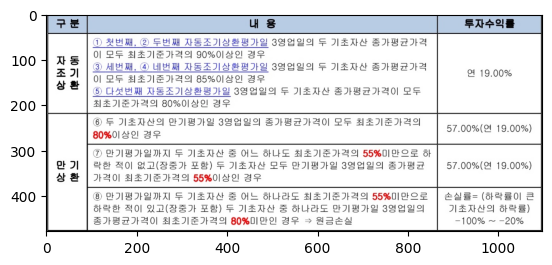

1
table: | 구 분분분분 구 구 구 | 내 용용용용 내 내 내 | 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |
| --- | --- | --- | --- |
| 상품유형 | 4Chance Step-down조기상환형 | 기초자산 | 한진해운 보통주, 대우조선해양 보통주 |
| 발행일 | 2007년 10월 26일 | 최초기준가격 | 한진해운: 54,000원 대우조선해양: 55,500원 |
| 만기일 | 2009년 10월 26일 | 만기평가가격 | 한진해운: 19,250원 대우조선해양: 17,400원 |
| 수익구조 | 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실 (전부 손실 가능) | 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실 (전부 손실 가능) | 주가 상승시 이익 발생, 주가 55% 초과 하락 시 원금 손실 (전부 손실 가능) |
| 투자손실금액 | 6,865만원 (원금손실금액) | 6,865만원 (원금손실금액) | 6,865만원 (원금손실금액) |
| 투자손실사유 | 해당상품은 각 기초자산의 주가 상승을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 생김. | 해당상품은 각 기초자산의 주가 상승을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 생김. | 해당상품은 각 기초자산의 주가 상승을 예상하고 설계된 구조로, 한진해운 보통주, 대우조선해양 보통주가 하락함에 따라 원금손실이 생김. |

----------------------------
summary: 이 표는 4Chance Step-down조기상환형 금융상품에 대한 정보를 보여줍니다. 2007년 10월 26일에 발행되어 2009년 10월 26일에 만기된 이 상품은 한진해운과 대우조선해양 주식을 기초자산으로 합니다. 최초 기준가격은 한진해운 54,000원, 대우조선해양 55,500원이었으나, 만기 평가 시 각각 19,250원과 17,400원으로 크게 하락했습니다. 이

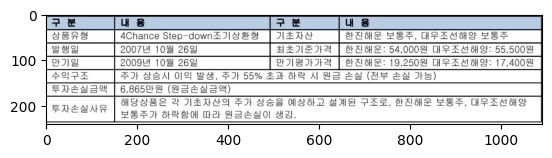

2
table: | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 |  | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 | 손익손익손익손익((((세전세전세전세전)))) |
| --- | --- | --- | --- | --- | --- | --- |
| 첫 번째 평가일 | 205,200.00원 | 102,600.00원 |  | 차기 평가일로 이월 | - | - |
| 두 번째 평가일 | 226,800.00원 | 113,400.00원 | 조기 상환 확정 |  | 19.00% | 1,900만원 |

----------------------------
summary: 이 표는 금융 상품의 조기상환 평가 결과를 보여줍니다. 표에는 현대차와 제일모직의 평가가격이 조기상환평가일별로 기록되어 있습니다.

첫 번째 평가일에서 현대차는 205,200원, 제일모직은 102,600원으로 평가되었으며, 조기상환 조건이 충족되지 않아 차기 평가일로 이월되었습니다.

두 번째 평가일에서는 현대차 226,800원, 제일모직 113,400원으로 평가되어 조기 상환이 확정되었고, 이에 따른 투자수익률은 19.00%로 세전 손익은 1,900만원입니다.
----------------------------
----------------------------
image


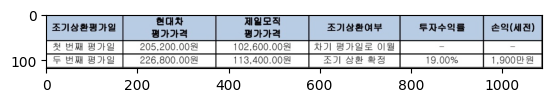

3
table: | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 | 손익손익손익손익((((세전세전세전세전)))) |
| --- | --- | --- | --- | --- | --- | --- |
| 첫 번째 평가일 | 첫 번째 평가일 | 205,200.00원 | 102,600.00원 | 차기 평가일로 이월 | - | - |
| 두 번째 평가일 | 두 번째 평가일 | 194,400.00원 | 97,200.00원 | 차기 평가일로 이월 | - | - |
| (중략) | (중략) | - | - | 차기 평가일로 이월 | - | - |
| 만기 | 사례1 | 172,800.00원 | 91,200.00원 | 만기 손실 확정* | -28.00% | -2,800.만원 |
| 평가일 | 사례2 | 201,600.00원 | 100,800.00원 | 만기 상환 확정** | 57.00% | 5,700만원 |

----------------------------
summary: 이 표는 특정 투자 상품의 조기상환 평가 결과를 보여줍니다. 첫 번째와 두 번째 평가일에는 현대차와 제일모직의 평가가격이 제시되어 있으나, 두 경우 모두 "차기 평가일로 이월"되었습니다. 

만기 평가일에서는 두 가지 사례가 제시됩니다:
1. 사례1: 현대차 172,800원, 제일모직 91,200원일 경우 만기 손실이 확정되어 -28% 수익률, -2,800만원의 손실이 발생
2. 사례2: 현대차 201,600원, 제일모직 100,800원일 경우 만기 상환이 확정되어 57% 수익률, 5,700만원의 이익이 발생

이 표는 주식 연계 투자 상품의 조기상환 조건과 만기 시 주가에 따른 수익률 시나리오를 보여

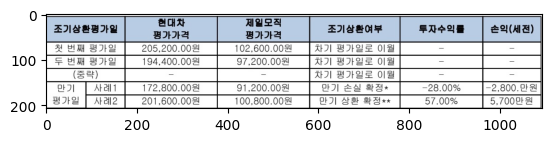

4
table: | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 |  | 손익손익손익손익((((세전세전세전세전)))) |
| --- | --- | --- | --- | --- | --- | --- |
| 첫 번째 평가일 | 205,200.00원 | 102,600.00원 | 차기 평가일로 이월 |  | - | - |
| 두 번째 평가일 | 194,400.00원 | 97,200.00원 | 차기 평가일로 이월 |  | - | - |
| (중략) | - | - | 차기 평가일로 이월 | - |  | - |
| 만기 평가일 | 138,600.00원 | 69,300.00원 | 만기 상환 확정*** |  | 57.00% | 5,700만원 |

----------------------------
summary: 이 표는 투자상품의 조기상환 평가 결과를 보여줍니다. 현대차와 제일모직 주식을 기초자산으로 하는 구조화 상품으로 보입니다. 첫 번째와 두 번째 평가일에는 두 종목 모두 조기상환 조건을 충족하지 못해 차기 평가일로 이월되었습니다. 중략된 평가일들을 거쳐 최종적으로 만기 평가일에는 현대차 주가가 138,600원, 제일모직 주가가 69,300원으로 확정되었고, 만기 상환이 확정되었습니다. 최종 투자수익률은 57.00%로 세전 손익은 5,700만원입니다.
----------------------------
----------------------------
image


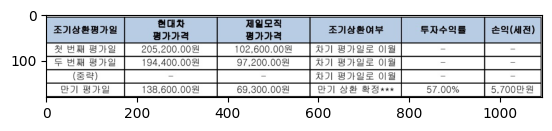

In [37]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(tables, table_summaries):

        #if table_as_image:
        #page_contents, table_as_html, img_base64 = table
        category, img_base64, table_as_html, page_contents = table["target_category"], table["target_base64"], table["target_markdown"], table["target_markdown"]
        #else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")

        print ("----------------------------")
        if img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


## 4. Index 생성
Document로 부터 추출한 text, table, 그리고 image 정보를 Amazon OpenSearch에 저장합니다. (인덱싱)  

### Index 이름 결정

In [38]:
import boto3
from utils.ssm import parameter_store

In [39]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [40]:
index_name = "complex-doc-index"

In [41]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [42]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [43]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [44]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [45]:
from utils.opensearch import opensearch_utils

In [46]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [47]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=complex-doc-index, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'complex-doc-index'}
Index is created
{'complex-doc-index': {'aliases': {},
                       'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                               'file_directory': {'type': 'text'},
                                                                               'image_base64': {'type': 'text'},
                                                                               'last_modified': {'type': 'text'},
                                                                               'origin_image': {'type': 'text'},
                                                                               'origin_table': {'type': 'text'},
                                                                               'page_nu

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [48]:
#from langchain.vectorstores import OpenSearchVectorSearch
from langchain_community.vectorstores import OpenSearchVectorSearch

In [49]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [50]:
from utils.chunk import parant_documents

In [51]:
parent_chunk_size = 4096
parent_chunk_overlap = 0

child_chunk_size = 1024
child_chunk_overlap = 256

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [52]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 3


* Insert doc into OpenSearch 

In [53]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 78.8 ms, sys: 1.52 ms, total: 80.3 ms
Wall time: 2.41 s


In [54]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 3, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.

In [55]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: 98e0bd4c-2d2d-473a-893a-b1f67b0204c4
family_tree: parent
parent document id: None
parent document text: 
 증진을 위하여 위하여 위하여
이해 증진을
이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해
금융상품에
보호
권익
금융소비자의
이
대한
설명서는
및
금융상품에 대한 이해 증진을 위하여
권익 보호 및 금융상품에
금융소비자의 권익
이해
대한
증진을
설명서는 금융소비자의
보호
이 설명서는
이
및
쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 상품내용을
이해하실
금융상품의 핵심내용을 쉽게
금융상품의
있도록
작성한
것입니다 . 상품내용을 상품내용을
수
핵심내용을
.
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다
있도록
핵심내용을
이해하실
것입니다
작성한
수
금융상품의
.
쉽게
다음에 청약여부를 결정하시기 바랍니다.... 바랍니다 바랍니다
충분히 이해하신 다음에
이해하신
청약여부를
결정하시기
충분히
다음에 청약여부를 결정하시기 바랍니다
충분히 이해하신 다음에
이해하신
청약여부를
결정하시기
충분히

# 핵심설명서 핵심설명서
핵심설명서 핵심설명서

파생결합증권 ELS)( 원금비보장형)])])])] 원금비보장형 원금비보장형
[미래에셋증권 제 2388 회 파생결합증권((((ELS)(
미래에셋증권
제
2388
회
[ 미래에셋증권 제 2388 회 파생결합증권 ELS)( 원금비보장형
회
제
[
파생결합증권
ELS)(
미래에셋증권
2388
[

# 상품 개요 개요 개요
1 1 상품
1 1
상품 개요
상품

- ○ 모집가액: 50억원 (모집된 금액이 10억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: 현대차 보통주, 제일모직 보통주
- ○ 청약기간: 2011년 05월 23일 ~ 2011년 05월 26일 14시까지
- ○ 청약단위: 100만원 이상 100만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일: 201

* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [56]:
# child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 13


In [57]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  98e0bd4c-2d2d-473a-893a-b1f67b0204c4

###### Search parent in OpenSearch
opensearch document id: 98e0bd4c-2d2d-473a-893a-b1f67b0204c4
family_tree: parent
parent document id: None
parent document text: 
 증진을 위하여 위하여 위하여
이해 증진을
이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해
금융상품에
보호
권익
금융소비자의
이
대한
설명서는
및
금융상품에 대한 이해 증진을 위하여
권익 보호 및 금융상품에
금융소비자의 권익
이해
대한
증진을
설명서는 금융소비자의
보호
이 설명서는
이
및
쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 상품내용을
이해하실
금융상품의 핵심내용을 쉽게
금융상품의
있도록
작성한
것입니다 . 상품내용을 상품내용을
수
핵심내용을
.
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다
있도록
핵심내용을
이해하실
것입니다
작성한
수
금융상품의
.
쉽게
다음에 청약여부를 결정하시기 바랍니다.... 바랍니다 바랍니다
충분히 이해하신 다음에
이해하신
청약여부를
결정하시기
충분히
다음에 청약여부를 결정하시기 바랍니다
충분히 이해하신 다음에
이해하신
청약여부를
결정하시기
충분히

# 핵심설명서 핵심설명서
핵심설명서 핵심설명서

파생결합증권 ELS)( 원금비보장형)])])])] 원금비보장형 원금비보장형
[미래에셋증권 제 2388 회 파생결합증권((((ELS)(
미래에셋증권
제
2388
회
[ 미래에셋증권 제 2388 회 파생결합증권 ELS)( 원금비보장형
회
제
[
파생결합증권
ELS)(
미래에셋증권
2388
[

# 상품 개요 개요 개요
1 1 상품
1 1
상품 개요
상품

- ○ 모집가액: 50억원 (모집된 금액이 10억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: 현대차 보통주, 제일모직 보통주
- ○ 청약기간: 2

In [58]:
child_chunk_docs[0]

Document(metadata={'family_tree': 'child', 'parent_id': '98e0bd4c-2d2d-473a-893a-b1f67b0204c4'}, page_content='증진을 위하여 위하여 위하여\n이해 증진을\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해\n금융상품에\n보호\n권익\n금융소비자의\n이\n대한\n설명서는\n및\n금융상품에 대한 이해 증진을 위하여\n권익 보호 및 금융상품에\n금융소비자의 권익\n이해\n대한\n증진을\n설명서는 금융소비자의\n보호\n이 설명서는\n이\n및\n쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 상품내용을\n이해하실\n금융상품의 핵심내용을 쉽게\n금융상품의\n있도록\n작성한\n것입니다 . 상품내용을 상품내용을\n수\n핵심내용을\n.\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다\n있도록\n핵심내용을\n이해하실\n것입니다\n작성한\n수\n금융상품의\n.\n쉽게\n다음에 청약여부를 결정하시기 바랍니다.... 바랍니다 바랍니다\n충분히 이해하신 다음에\n이해하신\n청약여부를\n결정하시기\n충분히\n다음에 청약여부를 결정하시기 바랍니다\n충분히 이해하신 다음에\n이해하신\n청약여부를\n결정하시기\n충분히\n\n# 핵심설명서 핵심설명서\n핵심설명서 핵심설명서\n\n파생결합증권 ELS)( 원금비보장형)])])])] 원금비보장형 원금비보장형\n[미래에셋증권 제 2388 회 파생결합증권((((ELS)(\n미래에셋증권\n제\n2388\n회\n[ 미래에셋증권 제 2388 회 파생결합증권 ELS)( 원금비보장형\n회\n제\n[\n파생결합증권\nELS)(\n미래에셋증권\n2388\n[\n\n# 상품 개요 개요 개요\n1 1 상품\n1 1\n상품 개요\n상품\n\n- ○ 모집가액: 50억원 (모집된 금액이 10억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: 현대차 보통주, 제일모직 보통주\n- ○ 청약기간: 2011년 05월 23일 ~ 2011년 05월 26일 1

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searcable list (child, parent_table and parent_image) in parant document strategy.

In [59]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [60]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

### Merge text, table and image

In [61]:
from itertools import chain

In [62]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

* Insert doc into OpenSearch

In [63]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  23
CPU times: user 102 ms, sys: 11.5 ms, total: 113 ms
Wall time: 3.34 s


## 6. 검색 테스트

In [64]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [68]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=2, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [69]:
%%time
query = "조기상환 여부에 따른 투자 수익률"
#query = "디지털 성범죄"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 8.43 ms, sys: 3.88 ms, total: 12.3 ms
Wall time: 107 ms



-----------------------------------------------
1. Category: Image, Chunk: 1060 Characters
-----------------------------------------------


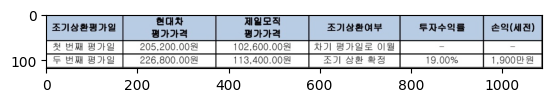

I'll analyze the provided table and contextual information for you.

## <title>
금융상품 조기상환 평가일 및 투자수익 정보

## <summary>
이 자료는 금융상품의 조기상환 평가일과 관련된 상환 조건을 보여주는 표입니다. 첫 번째와 두 번째 평가일에 대한 현대차와 제일모직의 평가가격 정보를 담고 있으며, 조기상환 여부와
투자수익률, 손익(세전) 정보를 제공합니다. 문서는 금융소비자의 권익 보호와 금융상품에 대한 이해 증진을 위한 설명서의 일부로, 상품의 손익구조와 투자 사례에 대해 자세히 설명하고
있습니다.

## <entities>
1. 조기상환평가일: 금융상품의 조기상환 가능성을 평가하는 일자
2. 현대차 평가가격: 기초자산인 현대차 주식의 평가 가격 (첫 번째 평가일 205,200원, 두 번째 평가일 226,800원)
3. 제일모직 평가가격: 기초자산인 제일모직 주식의 평가 가격 (첫 번째 평가일 102,600원, 두 번째 평가일 113,400원)
4. 조기상환여부: 해당 평가일에 조기상환 여부를 판단한 결과 (첫 번째는 차기 평가일로 이월, 두 번째는 조기상환 확정)
5. 투자수익률: 투자 시 얻을 수 있는 수익률 (두 번째 평가일에 19.00%)
6. 손익(세전): 투자금액에 대한 세전 손익 금액 (두 번째 평가일에 1,900만원)
7. 최초기준가격: 현대차 240,000원, 제일모직 120,000원으로 가정
8. 투자손익 사례: 1억원 투자 시 발생 가능한 다양한 시나리오별 손익 상황

## <hypothetical_questions>
1. 이 금융상품의 최대 수익률은 얼마인가요?
2. 조기상환이 발생하지 않을 경우, 만기에 손실이 발생할 수 있는 조건은 무엇인가요?
3. 현대차와 제일모직 주가가 최초기준가격의 55% 미만으로 하락한 적이 있을 때 어떤 영향이 있나요?
4. 만기평가일에 두 기초자산 모두 최초기준가격의 80% 이상일 경우 투자자에게 어떤 결과가 나타나나요?
5. 투자

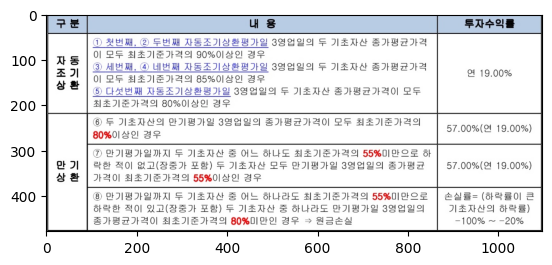

이 표는 투자상품의 수익률 조건을 설명하고 있습니다. 주요 내용은 다음과 같습니다:

1. 동자기조환상(자동조기상환) 조건:
   - 첫번째/두번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 90% 이상
   - 세번째/네번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 85% 이상
   - 다섯번째 평가일: 두 기초자산의 종가평균가격이 최초기준가격의 80% 이상
   - 수익률: 연 19.00%

2. 만기상환 조건:
   - 두 기초자산의 만기평가일 종가평균가격이 최초기준가격의 80% 이상인 경우: 57.00%(연 19.00%)
   - 만기까지 두 기초자산이 모두 55% 미만으로 하락한 적이 없고, 만기평가일에 55% 이상인 경우: 57.00%(연 19.00%)
   - 만기까지 하나라도 55% 미만으로 하락했고, 하나라도 만기평가일에 80% 미만인 경우: 원금손실(하락률이 큰 기초자산의 하락률에 따라 -20%에서 -100%까지)


metadata:
 {'origin_table': '| 구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- |
--- |\n| 동자 동 자 동자 동자 기조 기 기조 조 기조 환상 환 상 환상 환상 | ① 첫번째, ② 두번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두
최초기준가격의 90%이상인 경우 ③ 세번째, ④ 네번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 85%이상인 경우 ⑤ 다섯번째 자동조기상환평가일
3영업일의 두 기초자산 종가평균가격이 모두 최초기준가격의 80%이상인 경우 |  | 연 19.00% |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑥ 두 기초자산의
만기평가일 3영업일의 종가평균가격이 모두 최초기준가격의 80%80%80%80%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상
환상 | ⑦ 만기평가일까지 두 기초자산 중 어느 하나도 최초기준가격의 55%55%55%55%미만으로 하 락한 적이 없고(장중가 포함) 두 기초자산 모두 만기평가일 3영업일의
종가평균 가격이 최초기준가격의 55%55%55%55%이상인 경우 |  | 57.00%(연 19.00%) |\n| 만 기 기만 기만 기만 상 환 환상 환상 환상 | ⑧ 만기평가일까지
두 기초자산 중 어느 하나라도 최초기준가격의 55%55%55%55%미만으로 하락한 적이 있고(장중가 포함) 두 기초자산 중 하나라도 만기평가일 3영업일의 종가평균가격이
최초기준가격의 80%80%80%80%미만인 경우 ⇒ 원금손실 |  | 손실률= (하락률이 큰 기초자산의 하락률) -100% ~ -20% |\n', 'text_as_html': '|
구 분분분분 구 구 구 | 내 용용용용 내 내 내 |  | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- | --- |\n| 동자 동 자 동자

In [70]:
show_context_used(search_hybrid_result)

# SageMaker Processing Job 이용하기

## 1. scripy 만들기

In [123]:
%%writefile ./src/preprocessing.py

import os
import json
import copy
import boto3
import shutil
import argparse
from pprint import pprint
from utils import bedrock
from itertools import chain
from utils.bedrock import bedrock_info

from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from langchain.schema import Document
from pdf2image import convert_from_path
from requests_toolbelt import MultipartEncoder

import botocore
from utils.common_utils import retry
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

from utils.chunk import parant_documents
from utils.opensearch import opensearch_utils
from langchain_community.vectorstores import OpenSearchVectorSearch

class preprocess():
    
    def __init__(self, args):
        
        self.args = args
        self.proc_prefix = self.args.proc_prefix #'/opt/ml/processing'
        
        self.input_dir = os.path.join(self.proc_prefix, "input")
        self.output_dir = os.path.join(self.proc_prefix, "output")
        os.makedirs(self.input_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)
        
        print (os.listdir(self.input_dir))
        
        ############# 수정
        #self.file_path = os.path.join(self.input_dir, "sample-2.pdf")
        self.file_path = os.path.join(self.input_dir, self.args.file_name)
        #"./data/complex_pdf/sample-2.pdf"
        ###############
        
    def _initialization(self, ):
        
        self.boto3_bedrock = bedrock.get_bedrock_client(
            assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
            endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
            region=os.environ.get("AWS_DEFAULT_REGION", None),
        )
        
        self.llm_text = ChatBedrock(
            model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
            client=self.boto3_bedrock,
            streaming=True,
            callbacks=[StreamingStdOutCallbackHandler()],
            model_kwargs={
                "max_tokens": 2048,
                "stop_sequences": ["\n\nHuman"],
            }
        )
        
        self.llm_emb = BedrockEmbeddings(
            client=self.boto3_bedrock,
            model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
        )
        self.dimension = 1024
        
    def _document_parsing(self, ):
        
        runtime_sm_client = boto3.client('runtime.sagemaker')

        # Prepare multipart form data
        encoder = MultipartEncoder(
            fields={
                'document': (os.path.basename(self.file_path), open(self.file_path, 'rb'), 'application/pdf'),
                'model': 'document-parse',
                'ocr': 'auto',
                'coordinates': 'true',
                'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
                'base64_encoding': '["table", "figure"]'
            }
        )

        # Get the raw bytes of the multipart form data
        body = encoder.to_string()

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=self.args.endpoint_document_parser,
            ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
            Body=body
        )

        result = response["Body"].read()
        parse_output = json.loads(result)
        
        return parse_output
    
    def _extract_image_table(self, parse_output):
        
        def processing(**kwargs):
    
            category = kwargs["category"]
            markdown = kwargs["markdown"]
            base64_encoding = kwargs["base64_encoding"]
            coordinates = kwargs["coordinates"]
            page = kwargs["page"]
            docs = kwargs["docs"]

            if page in docs: 
                docs[page].append(
                    {
                        "category": category,
                         "markdown": markdown,
                         "base64_encoding": base64_encoding,
                         "coordinates": coordinates
                    }
                )
            else:
                docs[page] = [
                    {
                        "category": category,
                        "markdown": markdown,
                        "base64_encoding": base64_encoding,
                        "coordinates": coordinates
                    }
                ]

            return docs

        def image_conversion(**kwargs):

            image_path = kwargs["image_path"]
            file_path = kwargs["file_path"]

            image_tmp_path = os.path.join(image_path, "tmp")
            if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
            os.mkdir(image_tmp_path)

            # from pdf to image
            pages = convert_from_path(file_path)
            for i, page in enumerate(pages):
                print (f'pdf page {i}, size: {page.size}')    
                page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

            return image_tmp_path
        
        image_path = os.path.join(self.input_dir, "fig")
        if os.path.isdir(image_path): shutil.rmtree(image_path)
        os.mkdir(image_path)
        
        docs = {}
        texts = [
            Document(
                page_content=parse_output["content"]["markdown"]
            )
        ]

        ## extract_image_table
        image_tmp_path = image_conversion(
            image_path=image_path,
            file_path=self.file_path
        )

        for idx, value in enumerate(parse_output["elements"]):

            category = value["category"]
            markdown = value["content"]["markdown"]
            page = value["page"]

            if category in ["figure", "table"]:

                base64_encoding = value["base64_encoding"]    
                coordinates = value["coordinates"]    
                img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
                plt.imshow(img)
                plt.show()

                page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
                w, h = page_img.size  # PIL은 (width, height) 순서

                # 좌표 계산
                left = math.ceil(coordinates[0]["x"] * w)
                top = math.ceil(coordinates[0]["y"] * h)
                right = math.ceil(coordinates[1]["x"] * w)
                bottom = math.ceil(coordinates[3]["y"] * h)

                # PIL로 이미지 크롭
                crop_img = page_img.crop((left, top, right, bottom))
                        
                crob_image_path = f'{image_path}/element-{idx}.jpg'
                crop_img.save(crob_image_path)

                w_crop, h_crop = crop_img.size
                image_token = w_crop*h_crop/750
                print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
                
            else:
                base64_encoding= ""
                coordinates=""

            docs = processing(
                docs=docs,
                page=page,
                category=category,
                markdown=markdown,
                base64_encoding=base64_encoding,
                coordinates=coordinates
            )
            
        return docs, texts
    
    def _context_generation_for_image(self, docs):
        
        def manipulate_docs_for_summary(docs):
            
            docs_for_summary = []
            for page, elements in docs.items():

                elements = [element for element in elements if element["category"] != "footer"]
                print (f'page: {page}, # elements: {len(elements)}')

                for idx, element in enumerate(elements):

                    category, markdown = element["category"], element["markdown"]
                    print (f'element idx: {idx}, category: {element["category"]}')

                    elements_copy = copy.deepcopy(elements)
                    if category in ("figure", "table"):  
                        
                        summary_target = elements_copy.pop(idx)
                        contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
                        docs_for_summary.append(
                            {
                                "target_category": summary_target["category"],
                                "target_base64": summary_target["base64_encoding"],
                                "target_markdown": summary_target["markdown"],
                                "contexts_markdown": contexts_markdown
                            }
                        )
                
            return docs_for_summary
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

            human_prompt = [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/png;base64," + "{image_base64}",
                    },
                },
                {
                    "type": "text",
                    "text": '''
                             <contexts>
                             {contexts}
                             </contexts>

                             주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:

                             1. <title> 태그 안의 제목을 정확히 제시해주세요.
                             2. <summary> 태그 안의 내용을 요약해주세요.
                             3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                             4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                            모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)
            
            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
        def summary_img(summarize_chain, image_base64, contexts):

            img = Image.open(BytesIO(base64.b64decode(image_base64)))
            plt.imshow(img)
            plt.show()

            stream = summarize_chain.stream(
                {
                    "image_base64": image_base64,
                    "contexts": contexts
                }
            )
            response = ""
            for chunk in stream: response += chunk

            return response
            
        docs_for_summary = manipulate_docs_for_summary(docs)
        
        print ("docs_for_summary", len(docs_for_summary))
        
        
        summarize_chain = get_summary_chain()
        
        summaries = []
        for idx, doc in enumerate(docs_for_summary):
            summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
            summaries.append(summary)
            print ("\n==")
            print (idx)
            
        images_preprocessed = []
        for doc, summary in zip(docs_for_summary, summaries):

            metadata = {}
            metadata["markdown"] = doc["target_markdown"]
            metadata["category"] = "Image"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            images_preprocessed.append(doc)
            
        for image in images_preprocessed:
            image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"
        
        return images_preprocessed, docs_for_summary

    def _context_generation_for_table(self, docs_for_summary):
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
            
            human_prompt = [
                {
                    "type": "text",
                    "text": '''
                             Here is the table: <table>{table}</table>
                             Given table, give a concise summary.
                             Don't insert any XML tag such as <table> and </table> when answering.
                             Write in Korean.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = {"table": lambda x:x} | prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]
        summarize_chain = get_summary_chain()
        table_info = [t["target_markdown"] for t in tables]
        table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
        
        tables_preprocessed = []
        for doc, summary in zip(tables, table_summaries):

            metadata = {}
            metadata["origin_table"] = doc["target_markdown"]
            metadata["text_as_html"] = doc["target_markdown"]
            metadata["category"] = "Table"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            tables_preprocessed.append(doc)
        
        for table in tables_preprocessed:
            table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"
            
        return tables_preprocessed
    
    def _opensearch(self, ):
        
        index_body = {
            'settings': {
                'analysis': {
                    'analyzer': {
                        'my_analyzer': {
                                 'char_filter':['html_strip'],
                            'tokenizer': 'nori',
                            'filter': [
                                #'nori_number',
                                #'lowercase',
                                #'trim',
                                'my_nori_part_of_speech'
                            ],
                            'type': 'custom'
                        }
                    },
                    'tokenizer': {
                        'nori': {
                            'decompound_mode': 'mixed',
                            'discard_punctuation': 'true',
                            'type': 'nori_tokenizer'
                        }
                    },
                    "filter": {
                        "my_nori_part_of_speech": {
                            "type": "nori_part_of_speech",
                            "stoptags": [
                                "J", "XSV", "E", "IC","MAJ","NNB",
                                "SP", "SSC", "SSO",
                                "SC","SE","XSN","XSV",
                                "UNA","NA","VCP","VSV",
                                "VX"
                            ]
                        }
                    }
                },
                'index': {
                    'knn': True,
                    'knn.space_type': 'cosinesimil'  # Example space type
                }
            },
            'mappings': {
                'properties': {
                    'metadata': {
                        'properties': {
                            'source': {'type': 'keyword'},
                            'page_number': {'type':'long'},
                            'category': {'type':'text'},
                            'file_directory': {'type':'text'},
                            'last_modified': {'type': 'text'},
                            'type': {'type': 'keyword'},
                            'image_base64': {'type':'text'},
                            'origin_image': {'type':'text'},
                            'origin_table': {'type':'text'},
                        }
                    },
                    'text': {
                        'analyzer': 'my_analyzer',
                        'search_analyzer': 'my_analyzer',
                        'type': 'text'
                    },
                    'vector_field': {
                        'type': 'knn_vector',
                        'dimension': f"{self.dimension}" # Replace with your vector dimension
                    }
                }
            }
        }

        opensearch_domain_endpoint = self.args.opensearch_domain_endpoint
        opensearch_user_id = self.args.opensearch_user_id
        opensearch_user_password = self.args.opensearch_user_password
        index_name = self.args.index_name
        
        http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
        
        ## opensearch clinet 생성
        aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
        os_client = opensearch_utils.create_aws_opensearch_client(
            aws_region,
            opensearch_domain_endpoint,
            http_auth
        )
        
        ## opensearch index 생성
        index_exists = opensearch_utils.check_if_index_exists(
            os_client,
            index_name
        )

        if index_exists:
            opensearch_utils.delete_index(
                os_client,
                index_name
            )

        opensearch_utils.create_index(os_client, index_name, index_body)
        index_info = os_client.indices.get(index=index_name)
        print("Index is created")
        pprint(index_info)
        
        vector_db = OpenSearchVectorSearch(
            index_name=index_name,
            opensearch_url=opensearch_domain_endpoint,
            embedding_function=self.llm_emb,
            http_auth=http_auth, # http_auth
            is_aoss=False,
            engine="faiss",
            space_type="l2",
            bulk_size=100000,
            timeout=60
        )
        
        return os_client, vector_db, index_name
        
    def _chunking_and_indexing(self, os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed):
        
        parent_chunk_size = 4096
        parent_chunk_overlap = 0

        child_chunk_size = 1024
        child_chunk_overlap = 256

        opensearch_parent_key_name = "parent_id"
        opensearch_family_tree_key_name = "family_tree"
        
        parent_chunk_docs = parant_documents.create_parent_chunk(
            docs=texts,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name,
            parent_chunk_size=parent_chunk_size,
            parent_chunk_overlap=parent_chunk_overlap
        )
        print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')
        parent_ids = vector_db.add_documents(
            documents = parent_chunk_docs, 
            vector_field = "vector_field",
            bulk_size = 1000000
        )
        
        total_count_docs = opensearch_utils.get_count(os_client, index_name)
        print("total count docs: ", total_count_docs)
                
        # child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
        child_chunk_docs = parant_documents.create_child_chunk(
            child_chunk_size=child_chunk_size,
            child_chunk_overlap=child_chunk_overlap,
            docs=parent_chunk_docs,
            parent_ids_value=parent_ids,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name
        )

        print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")
        parent_id = child_chunk_docs[0].metadata["parent_id"]
        print("child's parent_id: ", parent_id)
        print("\n###### Search parent in OpenSearch")
        
        
        ## Merge
        docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))
        
        child_ids = vector_db.add_documents(
            documents=docs_preprocessed, 
            vector_field = "vector_field",
            bulk_size=1000000
        )
        print("length of child_ids: ", len(child_ids))
        
        return child_chunk_docs
        
    def execution(self, ):
        
        ## Initialization for Bedrock
        self._initialization()
        
        ## Document parsing
        parse_output = self._document_parsing()
        
        ## Context generation for images and tables
        docs, texts = self._extract_image_table(parse_output)
        images_preprocessed, docs_for_summary = self._context_generation_for_image(docs)
        tables_preprocessed = self._context_generation_for_table(docs_for_summary)
        
        ## Opensearch setting
        os_client, vector_db, index_name = self._opensearch()
        
        ## Chunking(Parent document) and indexing
        child_chunk_docs = self._chunking_and_indexing(os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed)
        
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--region", type=str, default="us-west-2")
    parser.add_argument("--proc_prefix", type=str, default="./src")
    parser.add_argument("--endpoint_document_parser", type=str, default="")
    parser.add_argument("--opensearch_domain_endpoint", type=str, default="")
    parser.add_argument("--opensearch_user_id", type=str, default="")
    parser.add_argument("--opensearch_user_password", type=str, default="")
    parser.add_argument("--index_name", type=str, default="")
    parser.add_argument("--file_name", type=str, default="")
    
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))
    
    os.environ['AWS_DEFAULT_REGION'] = args.region
        
    prep = preprocess(args)
    prep.execution()
    

Overwriting ./src/preprocessing.py


In [124]:
#!python ./src/preprocessing.py

## 2. parser용 이미지 생성하기
 **[중요] ECR 사용을 위해 "AmazonEC2ContainerRegistryFullAccess" policy를 role에 추가해야 합니다**

In [125]:
import sagemaker
from utils.ecr import ecr_handler

In [126]:
ecr = ecr_handler()
region=boto3.Session().region_name
strAccountID = boto3.client("sts").get_caller_identity().get("Account")

In [127]:
container_uri = sagemaker.image_uris.retrieve(
    framework="sklearn", version="1.2-1", region=region
)
container_uri

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3'

In [128]:
%%writefile ./custom-docker/Dockerfile-docparse

FROM 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3

RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | gpg --dearmor - | tee /usr/share/keyrings/kitware-archive-keyring.gpg >/dev/null
RUN apt-get update
RUN apt-get install -y libgl1-mesa-glx
RUN apt-get install -y libglib2.0-0
RUN apt-get install -y poppler-utils

RUN pip install -U pip
RUN pip install botocore==1.39.10
RUN pip install boto3==1.39.9
RUN pip install sagemaker==2.248.1
RUN pip install langchain==0.3.26
RUN pip install langchain_aws==0.2.29
RUN pip install langchain_community==0.3.20
RUN pip install requests_toolbelt==1.0.0
RUN pip install pdf2image==1.17.0
RUN pip install numpy==1.26.4
RUN pip install ipython==8.18.1
RUN pip install opensearch-py==3.0.0
RUN pip install matplotlib==3.9.4
RUN pip install pillow>=10.0.0

ENV PYTHONUNBUFFERED=TRUE

Overwriting ./custom-docker/Dockerfile-docparse


In [129]:
import botocore
botocore.__version__

'1.39.10'

In [130]:
strRepositoryName="docparse-image"  ## <-- 원하는 docker repostory 이름을 추가
strRepositoryName = strRepositoryName.lower()
strDockerFile = "Dockerfile-docparse"
strDockerDir = "./custom-docker/"
strTag = "latest"

In [131]:
## Build
#ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="ap-northeast-2", strAccountId="246618743249")
ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="us-west-2", strAccountId="246618743249")

/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/02_qa_chatbot/01_preprocess_docs
/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/02_qa_chatbot/01_preprocess_docs/custom-docker
strDockerFile Dockerfile-docparse
aws ecr get-login --region 'us-west-2' --registry-ids '246618743249' --no-include-email
Login Succeeded

Sending build context to Docker daemon   2.56kB

Step 1/21 : FROM 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
 ---> 10986b7522bd
Step 2/21 : RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | gpg --dearmor - | tee /usr/share/keyrings/kitware-archive-keyring.gpg >/dev/null
 ---> Using cache
 ---> 7eb1077ffffc
Step 3/21 : RUN apt-get update
 ---> Using cache
 ---> e672af535c74
Step 4/21 : RUN apt-get install -y libgl1-mesa-glx
 ---> Using cache
 ---> 5e5b71e966b9
Step 5/21 : RUN apt-get install -y libglib2.0-0
 ---> Using cache
 ---> 866961865858

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ubuntu/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credential-stores

DEPRECATED: The legacy builder is deprecated and will be removed in a future release.
            Install the buildx component to build images with BuildKit:
            https://docs.docker.com/go/buildx/



In [132]:
## Upload to ECR
strEcrRepositoryUri = ecr.register_image_to_ecr(region, strAccountID, strRepositoryName, strTag)

== REGISTER AN IMAGE TO ECR ==
  processing_repository_uri: 615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image:latest
aws ecr get-login --region 'us-west-2' --registry-ids '615299776985' --no-include-email


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ubuntu/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credential-stores



Login Succeeded

aws ecr create-repository --repository-name 'docparse-image'



An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'docparse-image' already exists in the registry with id '615299776985'


docker tag 'docparse-image:latest' '615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image:latest'
docker push '615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image:latest'
== REGISTER AN IMAGE TO ECR ==


In [ ]:
strEcrRepositoryUri = "615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image"

## 3. 파일 업로드 to S3

In [133]:
import sagemaker
from utils.s3 import s3_handler

In [134]:
sagemaker_session = sagemaker.Session()
strBucketName = sagemaker_session.default_bucket() # 기본 버킷 이름 가져오기
strLocalDataPath = "./data/complex_pdf/"

In [135]:
s3 = s3_handler()
source_dir, target_bucket, target_dir = strLocalDataPath, strBucketName, "doc_parse_data"
s3.upload_dir(source_dir, target_bucket, target_dir)

strS3DataPath = f's3://{strBucketName}/doc_parse_data'

This is a S3 handler with [None] region.
Upload:[./data/complex_pdf/] was uploaded to [s3://sagemaker-us-west-2-615299776985/doc_parse_data]successfully


## 3. Processing Job 실행

In [136]:
import os
from utils.ssm import parameter_store
from sagemaker import get_execution_role
#from sagemaker.pytorch.estimator import PyTorch
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

In [137]:
strRegionName = boto3.Session().region_name
strAccountId = boto3.client("sts").get_caller_identity().get("Account")
strPrefix = "doc-parse"

In [141]:
local_mode = False

#strExecutionRole = get_execution_role()
strExecutionRole = "<your sagemaker role>"
strExecutionRole = "arn:aws:iam::615299776985:role/service-role/AmazonSageMaker-ExecutionRole-20241014T132050"

if local_mode: 
    strInstanceType = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data", "complex_pdf"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

instance-type: ml.m5.xlarge
role: arn:aws:iam::615299776985:role/service-role/AmazonSageMaker-ExecutionRole-20241014T132050
bucket: sagemaker-us-west-2-615299776985
dataset-path: s3://sagemaker-us-west-2-615299776985/doc_parse_data
sagemaker_session: <sagemaker.session.Session object at 0x7449789a4fe0>


In [142]:
dataset_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version="1.2-1",
    py_version="py3",
    image_uri="615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image",#"<your image uri>"
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"
strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

pm = parameter_store(strRegionName)
endpoint_document_parser = "<endpoint-name>"
endpoint_document_parser = "Upstage-Document-Parse-2025-07-22-06-56-52-438"

opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)
opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)
opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)
index_name = "sm_prep_job"
file_name = "sample-2.pdf"

In [143]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--region", region, \
        "--endpoint_document_parser", endpoint_document_parser, \
        "--opensearch_domain_endpoint", opensearch_domain_endpoint, \
        "--opensearch_user_id", opensearch_user_id, \
        "--opensearch_user_password", opensearch_user_password, \
        "--index_name", index_name, \
        "--file_name", file_name
    ]
)


.............Received arguments Namespace(region='us-west-2', proc_prefix='/opt/ml/processing', endpoint_document_parser='Upstage-Document-Parse-2025-07-22-06-56-52-438', opensearch_domain_endpoint='https://search-dongjin-os-5gpta4ndudcjz354thd4hgokbi.us-west-2.es.amazonaws.com', opensearch_user_id='dongjin', opensearch_user_password='MarsEarth1!', index_name='sm_prep_job', file_name='sample-2.pdf')
['code', 'safety-administrator-job-manual.pdf', 'school_edu_guide.pdf', 'dart-short-sample.pdf', 'test.pdf', 'pickle', 'sample-2.pdf', 'sample.pdf', 'l-test.pdf', 'sales-portal.pdf', 'entrypoint', 'sample-3.pdf']
Create new client
  Using region: us-west-2
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)
pdf page 0, size: (1653, 2339)
pdf page 1, size: (1653, 2339)
pdf page 2, size: (1653, 2339)
image: /opt/ml/processing/input/fig/element-11.jpg, shape: (1462, 638), image_token_for_claude3: 1243.6746666666666
i

## 확인하기

In [144]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name="sm_prep_job",
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,

)

In [145]:
%%time
query = "조기상환 여부에 따른 투자 수익률"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 96 ms, sys: 2.92 ms, total: 99 ms
Wall time: 174 ms



-----------------------------------------------
1. Category: Image, Chunk: 847 Characters
-----------------------------------------------


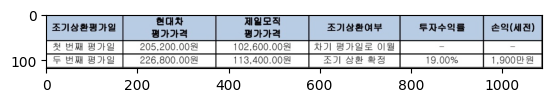

이 이미지와 주어진 정보를 바탕으로 요청하신 내용을 정리해드리겠습니다:

<title>조기상환평가일 및 투자수익률 분석</title>

<summary>
이 표와 그래프는 특정 금융 상품의 조기상환 조건과 투자 수익률을 보여줍니다. 현대차와 제일모직의 주가를 기준으로 조기상환 여부와 투자 수익률이 결정됩니다. 투자 기간 중 주가
변동에 따라 다양한 시나리오가 제시되어 있으며, 만기 시점의 주가에 따라 최종 수익률이 결정됩니다.
</summary>

<entities>
1. 현대차: 기초자산 중 하나로, 주가 변동이 투자 결과에 영향을 미침
2. 제일모직: 또 다른 기초자산으로, 현대차와 함께 주가 변동이 고려됨
3. 조기상환평가일: 투자 상품의 조기상환 여부를 결정하는 평가 시점
4. 최초기준가격: 투자 시작 시점의 기준 주가 (현대차 240,000원, 제일모직 120,000원 가정)
5. 투자수익률: 투자 결과에 따른 수익률, 최대 57.00%까지 가능
6. 손익(세전): 1억원 투자 시 예상되는 손익 금액
</entities>

<hypothetical_questions>
1. 만약 첫 번째 평가일에 두 기초자산 모두 최초기준가격의 85% 이상을 유지한다면 어떤 결과가 나타날까요?
2. 투자 기간 중 현대차 주가가 최초기준가격의 55% 미만으로 떨어졌다가 만기에 회복된다면 최종 수익률은 어떻게 될까요?
3. 만기 평가일에 두 기초자산 모두 최초기준가격의 80% 미만이지만 55% 이상을 유지한다면 투자자의 손익은 어떻게 될까요?
4. 조기상환이 한 번도 일어나지 않고 만기까지 갔을 때, 가장 유리한 시나리오와 불리한 시나리오는 각각 무엇일까요?
</hypothetical_questions>
metadata:
 {'markdown': '| 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직
제일모직 평가가격 평가가격 평가가격 평가가격 |  | 조기상환여부 조기상환

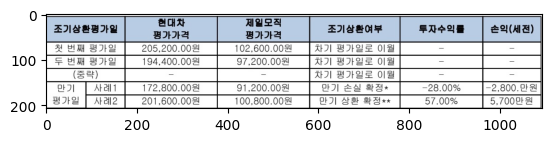

<title>수익률 그래프</title>

<summary>
이 이미지는 금융 상품의 손익구조와 투자 사례를 보여주는 표와 그래프입니다. 조기상환평가일의 기초자산 가격에 따른 투자 수익률과 손익을 설명하고 있습니다. 또한 투자 기간 중
기초자산 가격의 변동에 따른 다양한 시나리오를 제시하고 있습니다.
</summary>

<entities>
1. 현대차: 기초자산 중 하나로, 예시에서 최초기준가격은 240,000원으로 가정됨
2. 제일모직: 또 다른 기초자산으로, 예시에서 최초기준가격은 120,000원으로 가정됨
3. 조기상환평가일: 투자 상품의 조기상환 여부를 결정하는 평가일
4. 만기평가일: 투자 상품의 최종 수익률을 결정하는 평가일
5. 투자수익률: 투자 결과로 얻는 수익의 비율
6. 손익(세전): 투자로 인한 이익 또는 손실 금액 (세금 공제 전)
</entities>

<hypothetical_questions>
1. 첫 번째 조기상환평가일에 현대차와 제일모직의 주가가 각각 205,200원과 102,600원일 경우 투자자의 수익률은 어떻게 될까요?
2. 투자 기간 중 현대차 주가가 최초기준가격의 55% 미만으로 떨어졌다가, 만기평가일에 두 기초자산 모두 최초기준가격의 80% 이상으로 회복된다면 최종 수익률은 어떻게 될까요?
3. 만기평가일에 현대차와 제일모직의 주가가 각각 138,600원과 69,300원일 경우, 투자 기간 중 주가 변동에 따라 최종 수익률이 어떻게 달라질 수 있나요?
4. 두 번째 조기상환평가일에 현대차와 제일모직의 주가가 각각 226,800원과 113,400원일 경우 어떤 일이 발생하나요?
</hypothetical_questions>
metadata:
 {'markdown': '| 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차
평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가

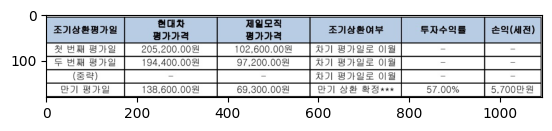

주어진 정보를 바탕으로 요청하신 내용을 정리해드리겠습니다.

<title>조기상환평가일별 기초자산 가격 및 상환 조건</title>

<summary>
이 표는 금융상품의 조기상환평가일에 따른 기초자산(현대차와 제일모직)의 가격 변동과 그에 따른 상환 조건을 보여줍니다. 첫 번째와 두 번째 평가일의 가격, 그리고 만기 시점의
다양한 시나리오에 따른 투자 수익률과 손익을 제시하고 있습니다. 또한 기초자산 가격의 변동에 따른 조기상환 여부와 투자 수익률의 변화를 상세히 설명하고 있습니다.
</summary>

<entities>
1. 조기상환평가일: 금융상품의 조기상환 가능성을 평가하는 날짜
2. 현대차: 기초자산 중 하나로, 해당 주식의 가격 변동이 상품 수익률에 영향을 줌
3. 제일모직: 또 다른 기초자산으로, 해당 주식의 가격 변동이 상품 수익률에 영향을 줌
4. 조기상환여부: 각 평가일에 상품이 조기상환되는지 여부를 나타냄
5. 투자수익률: 투자 결과에 따른 수익률 퍼센티지
6. 손익(세전): 투자 결과에 따른 실제 금액으로 표시된 손익
7. 최초기준가격: 각 기초자산의 초기 기준이 되는 가격
8. 만기평가일: 상품의 최종 평가가 이루어지는 날짜
</entities>

<hypothetical_questions>
1. 첫 번째 평가일에 현대차와 제일모직의 주가가 각각 205,200원과 102,600원일 경우, 조기상환이 이루어질까요?
2. 두 번째 평가일에 현대차와 제일모직의 주가가 각각 226,800원과 113,400원으로 상승하면 어떤 결과가 나타날까요?
3. 투자 기간 중 현대차 주가가 최초기준가격의 55% 미만으로 떨어진 적이 있고, 만기에 두 주식 모두 80% 미만일 경우 투자자의 손실은 얼마나 될까요?
4. 만기 평가일에 두 기초자산 모두 최초기준가격의 80% 이상을 유지하면 어떤 수익을 얻을 수 있나요?
5. 투자 기간 중 두 기초자산 모두 최초기준가격의 55% 이상을 유지했다면, 만기 시점의 수익률은 어떻게 될까요?
</hypothetical

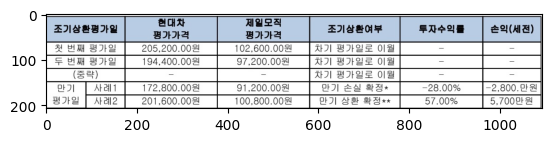

이 표는 특정 금융 상품의 조기상환 평가 결과를 보여줍니다. 주요 내용은 다음과 같습니다:

1. 조기상환평가일마다 현대차와 제일모직의 주가를 평가합니다.
2. 첫 번째와 두 번째 평가일에는 조기상환 조건을 충족하지 못해 차기 평가일로 이월됩니다.
3. 만기 시점에 두 가지 시나리오가 제시됩니다:
   - 사례1: 주가 하락으로 28% 손실(-2,800만원)이 발생합니다.
   - 사례2: 주가 상승으로 57% 수익(5,700만원)이 발생합니다.
4. 투자 수익률은 만기 시점의 주가 변동에 따라 크게 달라질 수 있음을 보여줍니다.

이 표는 해당 금융 상품의 위험성과 수익 가능성을 동시에 보여주고 있습니다.


metadata:
 {'origin_table': '| 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 |
현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 | 조기상환여부 조기상환여부 조기상환여부
조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 | 손익손익손익손익((((세전세전세전세전)))) |\n| --- | --- | --- | --- | --- | --- |
--- |\n| 첫 번째 평가일 | 첫 번째 평가일 | 205,200.00원 | 102,600.00원 | 차기 평가일로 이월 | - | - |\n| 두 번째 평가일 | 두 번째
평가일 | 194,400.00원 | 97,200.00원 | 차기 평가일로 이월 | - | - |\n| (중략) | (중략) | - | - | 차기 평가일로 이월 | - | -
|\n| 만기 | 사례1 | 172,800.00원 | 91,200.00원 | 만기 손실 확정* | -28.00% | -2,800.만원 |\n| 평가일 | 사례2 |
201,600.00원 | 100,800.00원 | 만기 상환 확정** | 57.00% | 5,700만원 |\n', 'text_as_html': '| 조기상환평가일 조기상환평가일
조기상환평가일 조기상환평가일 | 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직
제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 |
손익손익손익손익((((세전세전세전세전)))) |\n| --- | --- | --- | --- | --- | --- | --- |\n| 첫 번째 평가일 | 첫 번째 평가일 |
205,200.00원 | 102,600.00원 | 차기 평

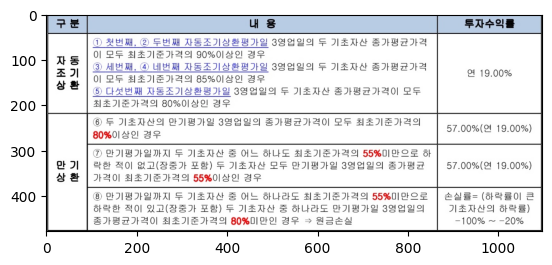

이 표는 투자 상품의 조건과 수익률을 설명하고 있습니다. 주요 내용은 다음과 같습니다:

1. 자동조기상환 조건: 특정 평가일에 기초자산의 가격이 일정 수준 이상일 때 연 19.00% 수익률로 상환됩니다.

2. 만기상환 조건:
   - 기초자산 가격이 최초 기준가격의 80% 이상일 때 57.00%(연 19.00%) 수익
   - 기초자산 가격이 55% 이상 80% 미만일 때도 동일한 수익 가능

3. 원금손실 가능성: 기초자산 가격이 55% 미만으로 하락한 적이 있고, 만기 시 80% 미만일 경우 원금 손실이 발생합니다.

이 상품은 높은 수익 가능성과 함께 원금 손실 위험도 있는 구조화된 투자 상품으로 보입니다.


metadata:
 {'origin_table': '| 구 분분분분 구 구 구 | 내 용용용용 내 내 내 | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- |\n|
동자 동 자 동자 동자 조 기 기조 기조 기조 환상 환 환상 상 환상 | ① 첫번째, ② 두번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의
90%이상인 경우 ③ 세번째, ④ 네번째 자동조기상환평가일 3영업일의 두 기초자산 종가평균가격 이 모두 최초기준가격의 85%이상인 경우 ⑤ 다섯번째 자동조기상환평가일 3영업일의 두
기초자산 종가평균가격이 모두 최초기준가격의 80%이상인 경우 | 연 19.00% |\n| 기만 기 만 기만 기만 환상 환 상 환상 환상 | ⑥ 두 기초자산의 만기평가일 3영업일의
종가평균가격이 모두 최초기준가격의 80%80%80%80%이상인 경우 | 57.00%(연 19.00%) |\n| 기만 기 만 기만 기만 환상 환 상 환상 환상 | ⑦ 만기평가일까지
두 기초자산 중 어느 하나도 최초기준가격의 55%55%55%55%미만으로 하 락한 적이 없고(장중가 포함) 두 기초자산 모두 만기평가일 3영업일의 종가평균 가격이 최초기준가격의
55%55%55%55%이상인 경우 | 57.00%(연 19.00%) |\n| 기만 기 만 기만 기만 환상 환 상 환상 환상 | ⑧ 만기평가일까지 두 기초자산 중 어느 하나라도
최초기준가격의 55%55%55%55%미만으로 하락한 적이 있고(장중가 포함) 두 기초자산 중 하나라도 만기평가일 3영업일의 종가평균가격이 최초기준가격의 80%80%80%80%미만인
경우 ⇒ 원금손실 | 손실률= (하락률이 큰 기초자산의 하락률) -100% ~ -20% |\n', 'text_as_html': '| 구 분분분분 구 구 구 | 내 용용용용 내 내
내 | 투자수익률 투자수익률 투자수익률 투자수익률 |\n| --- | --- | --- |\n| 동자 동 자 동자 동자 조 기 기조 기조 기조 환상 환 환상 상 환상 

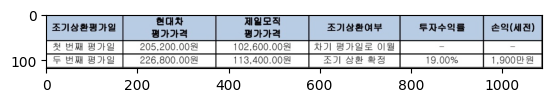

이 표는 특정 금융 상품의 조기상환 평가 결과를 보여줍니다. 두 번의 평가일이 있으며, 각 평가일마다 현대차와 제일모직의 주식 가격이 평가되었습니다. 첫 번째 평가일에는 조기상환
조건이 충족되지 않아 차기 평가일로 이월되었습니다. 두 번째 평가일에 조기상환이 확정되었으며, 투자수익률은 19.00%로 세전 손익은 1,900만원입니다. 이는 해당 금융 상품이
성공적으로 조기상환되어 투자자에게 좋은 수익을 가져다 주었음을 나타냅니다.


metadata:
 {'origin_table': '| 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격 평가가격 | 제일모직 제일모직
제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 |  | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률 투자수익률 |
손익손익손익손익((((세전세전세전세전)))) |\n| --- | --- | --- | --- | --- | --- | --- |\n| 첫 번째 평가일 | 205,200.00원 |
102,600.00원 |  | 차기 평가일로 이월 | - | - |\n| 두 번째 평가일 | 226,800.00원 | 113,400.00원 | 조기 상환 확정 |  | 19.00%
| 1,900만원 |\n', 'text_as_html': '| 조기상환평가일 조기상환평가일 조기상환평가일 조기상환평가일 | 현대차현대차현대차현대차 평가가격 평가가격 평가가격
평가가격 | 제일모직 제일모직 제일모직 제일모직 평가가격 평가가격 평가가격 평가가격 |  | 조기상환여부 조기상환여부 조기상환여부 조기상환여부 | 투자수익률 투자수익률 투자수익률
투자수익률 | 손익손익손익손익((((세전세전세전세전)))) |\n| --- | --- | --- | --- | --- | --- | --- |\n| 첫 번째 평가일 |
205,200.00원 | 102,600.00원 |  | 차기 평가일로 이월 | - | - |\n| 두 번째 평가일 | 226,800.00원 | 113,400.00원 | 조기 상환
확정 |  | 19.00% | 1,900만원 |\n', 'category': 'Table', 'image_base64': '', 'family_tree':
'parent_table', 'parent_id': 'NA', 'id': '6aebf36c-8ccb-4de9-bdb0-05f96060cd13', 'origin_image': '',
'orig_elements': ''

In [146]:
show_context_used(search_hybrid_result)